In [1]:
!nvidia-smi

Wed Jan 16 18:13:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    65W / 149W |      0MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
import sys
sys.path.append('..')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from radial.batchflow import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C, ImagesBatch, DatasetIndex, Batch
import radial.batchflow as ds
from radial.batchflow.models.tf import TFModel, VGG7
from radial import RadialBatch

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
plt.style.use('dark_background')

In [67]:
import random

class TmpBatch(ImagesBatch, RadialBatch, Batch):
    @property
    def components(self):
        """tuple of str: Data components names."""
        return "time", "derivative", "rig_type", "target", "predictions", "images", "img_target"

    @action
    def expand_dims(self, components=None):
        setattr(self, components, getattr(self, components).reshape((-1, 1)))
        return self
    
    @action
    def load(self, fmt=None, components=None, *args, **kwargs):
        if fmt == 'npz':
            RadialBatch.load(self, fmt=fmt, components=components, *args, **kwargs)
        elif fmt == 'image':
            ImagesBatch.load(self, fmt=fmt, components=components, *args, **kwargs)
        else:
            Batch.load(self, fmt=fmt, components=components, *args, **kwargs)
        return self

In [68]:
train_index = FilesIndex(path='january/train_npz/*.npz', no_ext=True)
train_set = Dataset(train_index, batch_class=TmpBatch)

test_index = FilesIndex(path='january/npz_with_predictions/*.npz', no_ext=True)
test_set = Dataset(train_index, batch_class=TmpBatch)

In [69]:
image_index = FilesIndex(path='january/image_data/*.png', no_ext=True)

In [70]:
load_ppl = (Pipeline()
                .load(fmt='npz', components=['time', 'derivative', 'rig_type', 'target'])
                .load(fmt='image', src=image_index, components='images')
                .resize((300, 200))
                .crop(origin='center', shape=(270, 180))
                .to_array()
                .multiply(1/255.)
                .load(fmt='csv', src='january/targets.csv', components='target', index_col='index')
#                 .expand_dims(components='img_target')
           )

In [71]:
img = (load_ppl << train_set).next_batch(2).images

AttributeError: can't set attribute

In [66]:
img[0].shape

(180, 270, 1)

In [27]:
(load_ppl << train_set).next_batch(2).target

array([49.09078762, 77.44617978])

In [28]:
(load_ppl << train_set).next_batch(2).time

array([array([1.53698776e+00, 5.66673931e+00, 6.34774095e+00, 6.54390030e+00,
       6.78394549e+00, 7.09554735e+00, 7.41284724e+00, 7.73727224e+00,
       8.06999249e+00, 8.25443038e+00, 8.67436144e+00, 8.88159443e+00,
       9.10776061e+00, 9.46895715e+00, 9.84034004e+00, 1.01919419e+01,
       1.04467839e+01, 1.09955041e+01, 1.16751920e+01, 1.21025479e+01,
       1.24667077e+01, 1.26404202e+01, 1.27992116e+01, 1.29741155e+01,
       1.31458801e+01, 1.33099375e+01, 1.34599238e+01, 1.36307653e+01,
       1.37876427e+01, 1.39425297e+01, 1.40955480e+01, 1.42739027e+01,
       1.45427463e+01, 1.47006234e+01, 1.49705389e+01, 1.51410246e+01,
       1.55660340e+01, 1.69013565e+01, 1.83486983e+01, 1.99070692e+01,
       2.06559776e+01, 2.07877996e+01, 2.09085345e+01, 2.10243067e+01,
       2.11360381e+01, 2.12210605e+01, 2.13254015e+01, 2.14476520e+01,
       2.15442415e+01, 2.16376709e+01, 2.18303767e+01, 2.23005512e+01,
       2.27776168e+01, 2.32269909e+01, 2.39172483e+01, 2.46027684e+01,

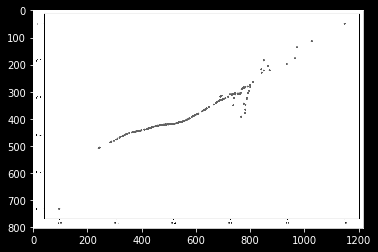

In [29]:
plt.imshow(img[1, :, :, 0],  cmap="gray")
plt.show()

In [30]:
model_config = {
    'inputs': dict(images=dict(shape=B('image_shape')),
                             labels={'shape': (1), 'name': 'targets'}),
    'body': dict(layout='cpna cpna cpna cpna', filters=[16, 32, 64, 128],
                 strides=2, pool_strides=2, kernel_size=3),
    'head': dict(layout='Pf', units=1),
    'initial_block/inputs': 'images',
    'loss': 'mse',
    
    'optimizer': ('Momentum', {'use_nesterov': True, 'learning_rate': 0.01, 'momentum': 0.5})}

In [14]:
train_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .init_model('dynamic', TFModel, 'image_model', config=model_config)
                  .to_array()
                  .train_model('image_model', fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('img_target')}, 
                               save_to=V('loss'), mode='w')
                  .update_variable('loss_history', V('loss'), mode='a'))

train_pipeline = (load_ppl + train_template) << train_set

test_template = (Pipeline()
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('loss_history', init_on_each_run=list)
                  .import_model('image_model', train_pipeline)
                  .to_array()
                  .train_model('image_model', fetches=['loss', 'predictions'],
                               feed_dict={'images': B('images'),
                                          'labels': B('img_target')}, 
                               save_to=[V('loss'), B('predictions')], mode='w')
                  .update_variable('loss_history', V('loss'), mode='a')
                )

In [15]:
test_pipeline = (load_ppl + test_template) << test_set

In [16]:
train_pipeline.get_variable('loss_history')

In [17]:
train_pipeline.reset_iter()

In [18]:
train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)
train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)

# train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)
# train_pipeline.next_batch(16, shuffle=True, n_epochs=10, drop_last=False, bar=True)

  1%|          | 2/195 [00:04<07:07,  2.22s/it]

In [19]:
(train_pipeline.get_variable('loss_history'))

[2.7653441, 4.86022]

In [20]:
# for i in tqdm(range(500)):
train_pipeline.run(16, shuffle=True, n_epochs=20, drop_last=False, bar=True)
test_pipeline.run(16, shuffle=True, n_epochs=20, drop_last=False, bar=True)


100%|█████████▉| 388/389 [01:11<00:00,  5.40it/s]


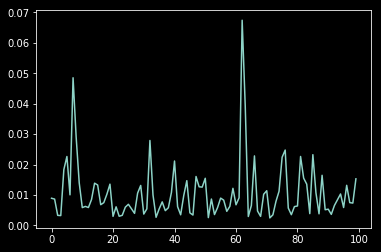

In [21]:
plt.plot(train_pipeline.get_variable('loss_history')[-100:])

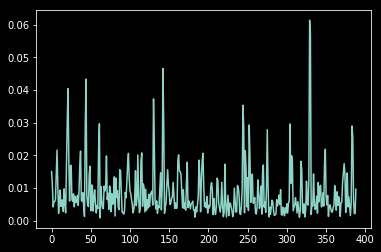

In [22]:
plt.plot(test_pipeline.get_variable('loss_history'))

In [ ]:
predict_pipeline = (test_pipeline
                        .apply_transform(log, src=['time', 'derivative', 'target'],
                             dst=['log_time', 'log_derivative', 'log_target'])
                        .normalize(src=['log_time', 'log_derivative'], dst=['log_norm_time', 'log_norm_derivative'],\
                                   dst_range=[None, 'log_derivative_range'])
                        .normalize(src='log_target', dst='log_norm_target', src_range='log_derivative_range')

                        .denormalize(src='predictions', dst='denorm_predictions',
                                         src_range='derivative_range')

                   )

In [23]:
btch = test_pipeline.next_batch(len(test_set.indices), shuffle=True, n_epochs=None, drop_last=False, bar=True)

  0%|          | 0/9223372036854775807 [00:00<?, ?it/s]

In [25]:
metrics = np.abs(btch.predictions.reshape(-1) - btch.img_target.reshape(-1)) / btch.img_target.reshape(-1)
metrics = metrics.astype(np.float32)

In [26]:
np.mean(metrics)

0.072238036

In [27]:
np.percentile(metrics, q=90)

0.11348072439432144

(array([34., 45., 52., 47., 43., 33., 23., 11.,  7.,  6.]),
 array([1.33050053e-04, 1.60458364e-02, 3.19586228e-02, 4.78714092e-02,
        6.37841955e-02, 7.96969819e-02, 9.56097683e-02, 1.11522555e-01,
        1.27435341e-01, 1.43348127e-01, 1.59260914e-01]),
 <a list of 10 Patch objects>)

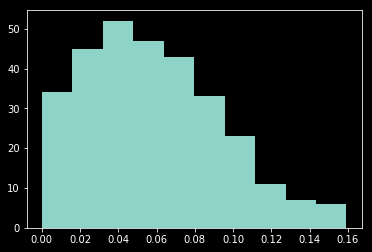

In [28]:
plt.hist(np.sort(metrics)[:-10])

(array([8., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.15955552, 0.40433396, 0.64911239, 0.89389082, 1.13866926,
        1.38344769, 1.62822613, 1.87300456, 2.11778299, 2.36256143,
        2.60733986]),
 <a list of 10 Patch objects>)

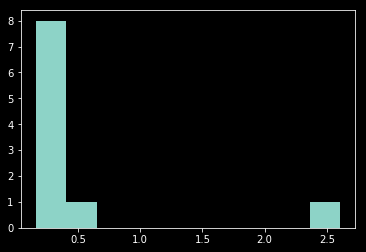

In [29]:
plt.hist(np.sort(metrics)[-10:])

In [71]:
metrics[ix]

array([3.38676211e-04, 2.39271321e-03, 5.29506104e-03, 7.89827295e-03,
       1.02409646e-02, 1.05285756e-02, 1.15940245e-02, 1.25635006e-02,
       1.36993080e-02, 1.37324166e-02, 1.54519714e-02, 1.70443021e-02,
       1.75278578e-02, 1.87743716e-02, 1.95394959e-02, 2.11553089e-02,
       2.47574747e-02, 2.48929448e-02, 2.65882611e-02, 2.69453973e-02,
       2.81103011e-02, 2.88722198e-02, 3.01212054e-02, 3.01644169e-02,
       3.12228389e-02, 3.33514959e-02, 3.34046185e-02, 3.34928520e-02,
       3.40413488e-02, 3.48892771e-02, 3.66538204e-02, 3.85907516e-02,
       3.99010107e-02, 3.99260409e-02, 4.02413309e-02, 4.03114930e-02,
       4.07385565e-02, 4.09150608e-02, 4.11261432e-02, 4.13349792e-02,
       4.32876013e-02, 4.37441133e-02, 4.40585613e-02, 4.41188030e-02,
       4.55000550e-02, 4.59647886e-02, 4.60316539e-02, 4.73369174e-02,
       5.06119244e-02, 5.10642566e-02, 5.14053553e-02, 5.28854877e-02,
       5.29529229e-02, 5.34983166e-02, 5.40410243e-02, 5.43796085e-02,
      

In [69]:
ix = np.argsort(metrics)

Let's have a look at the worst predictions

target=[0.08417477], prediction=[0.00941108]


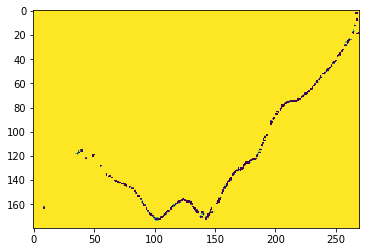

target=[0.16234007], prediction=[0.09310725]


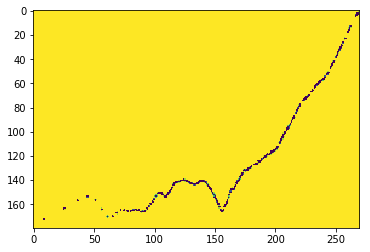

target=[0.20060855], prediction=[0.1293277]


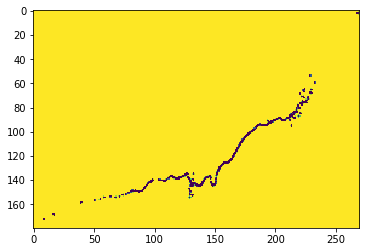

target=[0.2445937], prediction=[0.20177467]


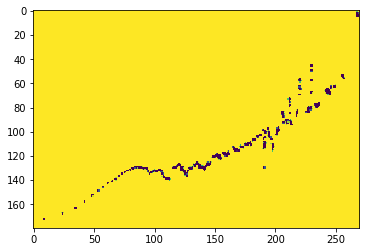

target=[0.40060473], prediction=[0.34396052]


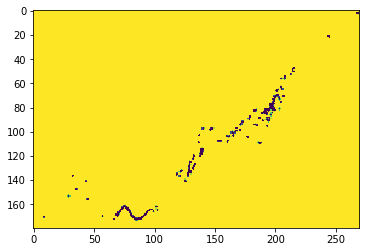

target=[0.58608118], prediction=[0.50735754]


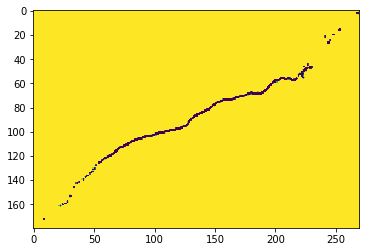

target=[0.72928179], prediction=[0.63245475]


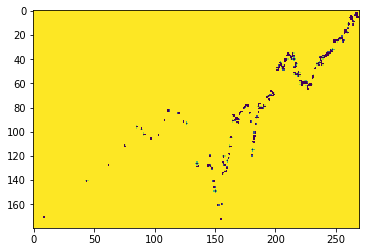

target=[0.37242753], prediction=[0.3243207]


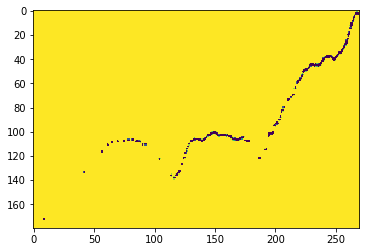

target=[0.25854877], prediction=[0.22563797]


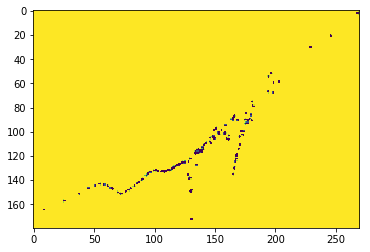

target=[0.49088753], prediction=[0.43117443]


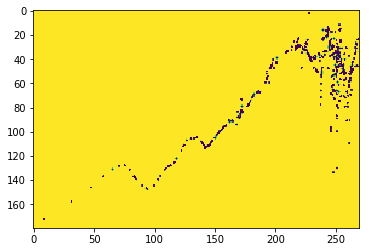

target=[0.50525921], prediction=[0.44751707]


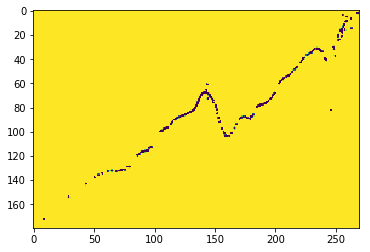

target=[0.39728201], prediction=[0.35875973]


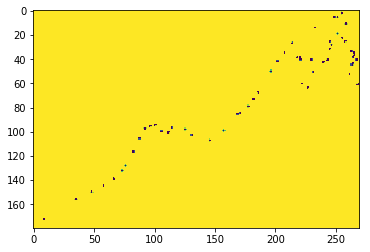

target=[0.58819298], prediction=[0.53203404]


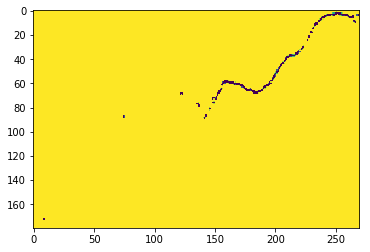

target=[0.80756543], prediction=[0.73195076]


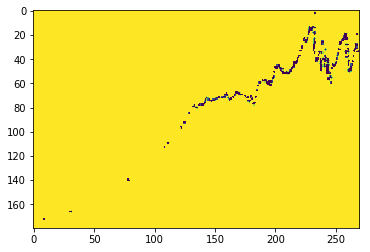

target=[0.69589617], prediction=[0.63176656]


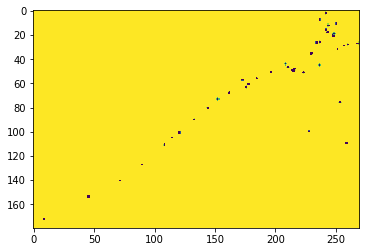

target=[0.45940881], prediction=[0.41897598]


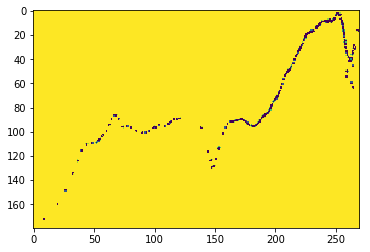

target=[0.43863827], prediction=[0.40051362]


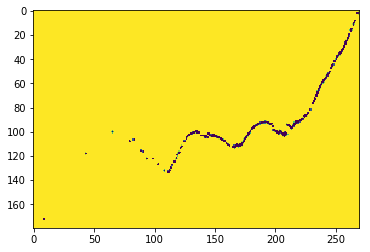

target=[0.7890692], prediction=[0.7236248]


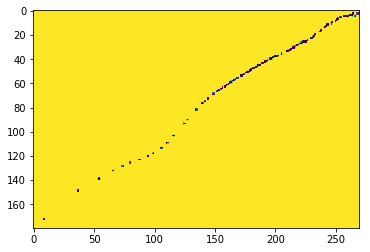

target=[0.79673921], prediction=[0.7315373]


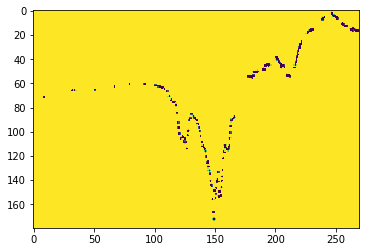

In [70]:
for i in range(1, 20):
    plt.imshow(btch.images[ix][-i, :, :, 0])
    print('target={}, prediction={}'.format(btch.target[ix][-i], btch.predictions[ix][-i]))
    plt.show()

# Train and test loss

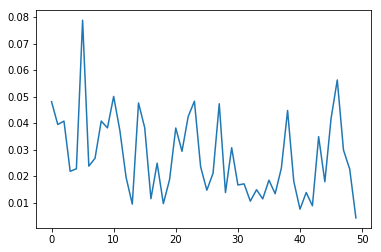

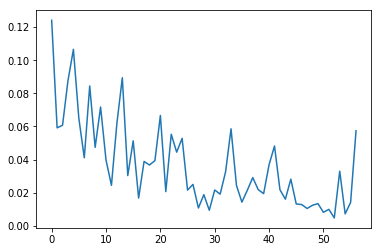

In [62]:
plt.plot(train_pipeline.get_variable('loss_history')[-50:])
plt.show()

plt.plot(test_pipeline.get_variable('loss_history'))
plt.show()

looks pretty much the same as the non-image models